# Simulating bent waveguides using the EME solver

**Warning. The cost of running this notebook is larger than 50 FC.** The cost of running the FDTD portion of the notebook is about 60 FlexCredits. The cost of running the EME portion is less than 5.

EME is a frequency-domain technique used for propagating electromagnetic fields and calculating the complete bidirectional scattering matrix. It is particularly useful for simulating long waveguides, as it can be significantly faster and more cost-effective than FDTD. In the EME solver, the waveguide is divided into cells, and the bidirectional scattering matrix is calculated at its boundaries. Therefore, the method is suitable for waveguides with adiabatic variations, where the relative error compared to a full-wave FDTD simulation can be small.

Additionally, the EME solver can be used to simulate bent waveguides, either by concatenating circular sections with different bend radii or by creating a grid to capture the variations in the local radius for an arbitrary bend. However, the workflow might be counterintuitive, as the EME simulation consists of a **straight** geometry, with each EME cell representing a local curvature. This is depicted in the above picture, where a waveguide formed by a combination of circular arcs in FDTD is modeled as a straight waveguide in EME, with each cell accounting for the curvature radius of each section.

<img src="img/EMEBends.png" width="700" alt="Schematic">

In this notebook, we will demonstrate the use of the EME solver for analyzing bent structures through the following examples:

1. S-shape bend composed of two semi-circles with identical bend radii
2. Coupling arms formed by several semi-circles
3. S-shape Euler bend composed of two clothoid curves

Also, we will compare the results obtained with the EME solver with the ones obtained with an FDTD simulation.

More information about the EME solver can be found in [this](https://www.flexcompute.com/tidy3d/examples/notebooks/EMESolver/) example notebook.

In [1]:
# import libraries
import tidy3d as td
import numpy as np
import matplotlib.pyplot as plt
from tidy3d import web

# suppress warnings during calculations
import warnings
warnings.filterwarnings("ignore")

## Circular Bends

The EME cells will be defined with the [`EMEExplicitGrid`](https://docs.flexcompute.com/projects/tidy3d/en/v2.7.3/api/_autosummary/tidy3d.EMEExplicitGrid.html) object, which allows us to position EME grid cells in specific positions. The first and last cells will simulate straight sections, which are the input and output waveguides of the device. The intermediate cells are a combination of circular arcs. The S-bend is formed by two circular arcs with a radius of curvature of equal magnitude but different signs, which represent a counter-clockwise and clockwise curvature. The curvature radius is defined in the [`EMEModeSpec`](https://docs.flexcompute.com/projects/tidy3d/en/v2.7.3/api/_autosummary/tidy3d.EMEModeSpec.html) object.

For all examples, the structures will consist of Silicon Nitride waveguides buried in $\text{SiO}_2$.

Firstly, we will define a function for creating the EME simulation. For defining the bend region, we will input a list of tuples, where each tuple will have the information of the length and bend radius of a given cell.

In [2]:
def get_bend_eme(
    bends=[(1, 1)],
    wvgIn=2,
    wvgOut=2,
    width=0.6,
    thickness=0.4,
    plane_size=(6, 6),
    num_modes=5,
    target_neff=1.545645,
    core_index=2,
    precision="double",
    store_port_modes=False,
):
    """
    Creates and returns an EME simulation for a bent waveguide structure.

    Parameters:
        bends (list of tuple): A list of tuples where each tuple represents a bend in the waveguide.
                                Each tuple consists of two values: length and bend radius. Default is [(1, 1)].
        wvgIn (float): The length of the straight waveguide section at the input. Default is 2.
        wvgOut (float): The length of the straight waveguide section at the output. Default is 2.
        width (float): The width of the waveguide. Default is 0.6.
        thickness (float): The thickness of the waveguide core. Default is 0.4.
        plane_size (tuple): The size of the simulation plane (height, width). Default is (6, 6).
        num_modes (int): The number of modes to compute for the simulation. Default is 5.
        target_neff (float): The target effective index for the modes. Default is 1.545645.
        core_index (float): The refractive index of the core material. Default is 2.
        precision (str): The numerical precision for the simulation, either "single" or "double". Default is "double".
        store_port_modes (bool): Whether to store port modes. Default is False.
    """

    # default mode spec
    mode_spec = td.EMEModeSpec(
        num_modes=num_modes,
        bend_radius=None,
        bend_axis=1,
        num_pml=(12, 12),
        target_neff=target_neff,
        precision=precision,
    )

    # size of the EME simulation. Start with 2 to compensate the port offsets
    size = 2

    # add straight sections
    if wvgIn > 0:
        bends = [(wvgIn, None)] + bends
    if wvgOut > 0:
        bends = bends + [(wvgOut, None)]

    structures = []
    mode_specs = []

    # iterate through each section and create each mode spec
    for i, bend in enumerate(bends):

        length, radius = bend

        mode_specs.append(mode_spec.updated_copy(bend_radius=radius))

        if i == 0:
            boundaries = [length]
        else:
            boundaries.append(boundaries[-1] + length)

        size += length

    eme_grid_spec = td.EMEExplicitGrid(
        boundaries=boundaries[:-1], mode_specs=mode_specs
    )

    # monitor for visualizing fields
    eme_field_mon = td.EMEFieldMonitor(name="field", size=(td.inf, 0, td.inf))

    # EME mode monitor:
    eme_mode_mon = td.EMEModeSolverMonitor(
        name="modes",
        size=(td.inf, td.inf, td.inf),
        center=(0, 0, 0),
    )

    # creating structures

    sio2 = td.material_library["SiO2"]["Palik_Lossless"]
    core = td.Medium(permittivity=core_index**2)

    # creating waveguide structure
    structures = [
        td.Structure(
            attrs={},
            geometry=td.PolySlab(
                axis=2,
                sidewall_angle=0.0,
                slab_bounds=(-thickness / 2, thickness / 2),
                vertices=np.array(
                    [
                        [-1e15, -width / 2],
                        [-1e15, width / 2],
                        [1e15, width / 2],
                        [1e15, -width / 2],
                    ]
                ),
            ),
            medium=core,
        )
    ]

    # creating the simulation object
    sim = td.EMESimulation(
        size=(size, plane_size[0], plane_size[1]),
        medium=sio2,
        center=(size / 2 - 1, 0, 0),
        structures=structures,
        axis=0,
        freqs=[td.C_0 / 1.55],
        eme_grid_spec=eme_grid_spec,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
        monitors=[eme_field_mon, eme_mode_mon],
        port_offsets=(1, 1),
        symmetry=(0, 0, 1),
        store_port_modes=store_port_modes,
    )

    return sim

For each EME simulation, we will also create an equivalent FDTD simulation to explicitly simulate the curvature. For convenience, we will define auxiliary functions for creating a list of x and y points for a given EME simulation object, that can later be used to generate the correct structure for the FDTD simulation:

In [3]:
# function for creating points for an arc section
def arc(length, radius, center=(0, 0), theta0=0):
    theta = theta0 + np.linspace(0, length, 1001) / radius
    x = radius * np.cos(theta - np.pi / 2)
    y = radius * np.sin(theta - np.pi / 2)

    x = x + (center[0] - x[0])
    y = y + (center[1] - y[0])
    return x, y, theta


# function for creating points for a straight section at a given angle
def line(length, theta, center=(0, 0)):
    x = [center[0], center[0] + length * np.cos(theta)]
    y = [center[1], center[1] + length * np.sin(theta)]

    return x, y


# function for creating a list of points representing the bend waveguide from an EME simulation object
def eme2Curve(sim):

    mode_specs = sim.eme_grid_spec.mode_specs
    boundaries = sim.eme_grid_spec.boundaries
    boundaries = np.append(0, boundaries)
    boundaries = np.append(boundaries, sim.size[0] - sum(sim.port_offsets))
    lengths = np.diff(boundaries)
    radius = [i.bend_radius for i in mode_specs]

    x, y = [], []

    cx, cy = 0, 0
    theta = 0
    for i, r in enumerate(radius):
        if r:
            a, b, t = arc(lengths[i], r, (cx, cy), theta0=theta)
            theta = t[-1]
        else:
            a, b = line(lengths[i], theta, (cx, cy))
        x = np.append(x, a)
        y = np.append(y, b)

        cx = x[-1]
        cy = y[-1]

    return x, y

Next, we will create a function to return an FDTD simulation object, given as input a list of x and y coordinates of the waveguide structure. To analyze the transmission, a [`ModeMonitor`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) is placed at the end of the last straight section, in the same position as the last cell of the EME grid. For analyzing modes that are not parallel with the *x* or *y* axis, we will input the correct `angle_theta` parameter in the [`ModeSpec`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSpec.html) object.

In [4]:
def get_fdtd(x, y, sim, width=0.6, thickness=0.4):

    # output angle
    theta = np.arctan2(y[-1] - y[-2], x[-1] - x[-2])

    # simulation size
    sx = max(x) - min(x)
    sy = max(y) - min(y)

    # simulation center
    centerX = min(x) + sx / 2
    centerY = min(y) + sy / 2

    # adding extra size so the structures will not start or end at the PML boundaries
    x = np.append([-5, 0], x)
    y = np.append([0, 0], y)

    cx = x[-1]
    cy = y[-1]

    a, b = line(5, theta, (cx, cy))
    x = np.append(x, a)
    y = np.append(y, b)

    # creating the structure with gdstk
    import gdstk

    cell = gdstk.Cell("bends")
    cell.add(gdstk.FlexPath(x + 1j * y, width, layer=1, datatype=0))

    geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(-thickness / 2, thickness / 2),
    )[0]

    # simulation size
    size = (sx + 4, sy + 5, 3)

    # structure and source
    fdtd_structure = td.Structure(geometry=geo, medium=sim.structures[0].medium)

    source = td.ModeSource(
        center=(0, 0, 0),
        size=(0, 3, 3),
        direction="+",
        mode_spec=td.ModeSpec(num_modes=1),
        source_time=td.GaussianPulse(freq0=td.C_0 / 1.55, fwidth=0.1 * td.C_0 / 1.55),
    )

    while theta >= 2 * np.pi:
        theta -= 2 * np.pi

    thetaDeg = 180 * theta / np.pi

    # adjusting monitor size for the output angle
    if (thetaDeg > -45) and (thetaDeg <= 45):
        mon_size = (0, 3, 3)
    elif (thetaDeg > 45) and (thetaDeg <= 135):
        mon_size = (3, 0, 3)
    elif (thetaDeg > 135) and (thetaDeg <= 225):
        mon_size = (0, 3, 3)
    else:
        mon_size = (3, 0, 3)

    # monitors
    fieldMon = td.FieldMonitor(
        name="field", center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[td.C_0 / 1.55]
    )

    # adjusting the theta angle of the output monitor
    if abs(theta - np.pi / 2) < 0.05 or abs(theta - np.pi) < 0.05:

        modeMon = td.ModeMonitor(
            name="modeMon",
            size=mon_size,
            center=(cx, cy, 0),
            freqs=[td.C_0 / 1.55],
            mode_spec=source.mode_spec,
        )

    else:
        # adjusting the correct angle for each quadrant
        if thetaDeg <= 90:
            t = theta
        if (thetaDeg > 90) and (thetaDeg <= 180):
            t = -(theta - np.pi / 2)
        if (thetaDeg > 180) and (thetaDeg <= 270):
            t = (theta - np.pi) + theta - np.pi / 2
        if (thetaDeg > 270) and (thetaDeg <= 360):
            t = -(theta - 3 * np.pi / 2)

        modeMon = td.ModeMonitor(
            center=(cx, cy, 0),
            size=mon_size,
            freqs=[td.C_0 / 1.55],
            mode_spec=td.ModeSpec(
                num_modes=5,
                angle_theta=t,
                angle_phi=0,
            ),
            name="modeMon",
        )

    sim_fdtd = td.Simulation(
        size=size,
        center=(centerX, centerY, sim.center[2]),
        medium=sim.medium,
        grid_spec=sim.grid_spec,
        sources=[source],
        monitors=[fieldMon, modeMon],
        run_time=10e-12,
        structures=[fdtd_structure],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.absorber(), y=td.Boundary.absorber(), z=td.Boundary.pml()
        ),
        symmetry=(0, 0, 1),
    )

    return sim_fdtd

### Plane Size and Mode Index

As a sanity check, let's start with a simple 90-degree bend:

In [5]:
radius = 50
length = radius * np.pi / 2

eme_sim = get_bend_eme(
    bends=[(length, radius)],
    wvgIn=2,
    wvgOut=2,
    plane_size=(6, 6),
)

x, y = eme2Curve(eme_sim)
fdtd_sim = get_fdtd(x, y, eme_sim)

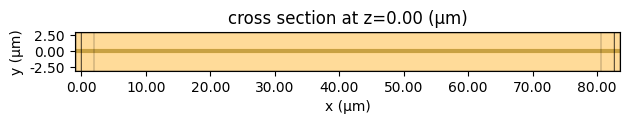

In [6]:
# plotting the EME simulation
eme_sim.plot(z=0)
plt.show()

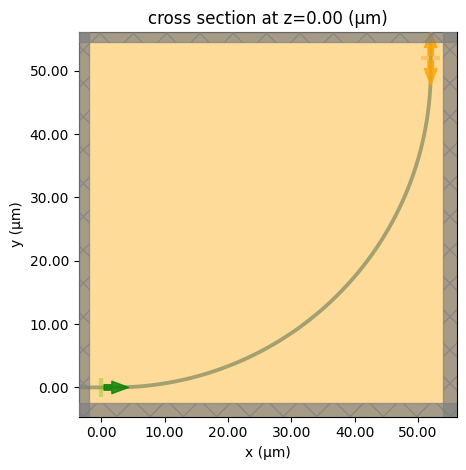

In [7]:
# plotting the FDTD simulation
fdtd_sim.plot(z=0)
plt.show()

In [8]:
# running EME simulation
eme_data = web.run(eme_sim, task_name='eme',verbose = True)

18:22:35 -03 Created task 'eme' with task_id                                    
             'eme-4dd51612-1ef8-43d7-999d-4f4ac08d15a2' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:22:37 -03 Maximum FlexCredit cost: 0.110. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:22:38 -03 status = success

18:23:15 -03 loading simulation from simulation_data.hdf5

18:23:16 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

In [9]:
# analyzing the transmittance
t = float(eme_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs ** 2)
print("Transmittance: %f" % t)

Transmittance: 0.000000


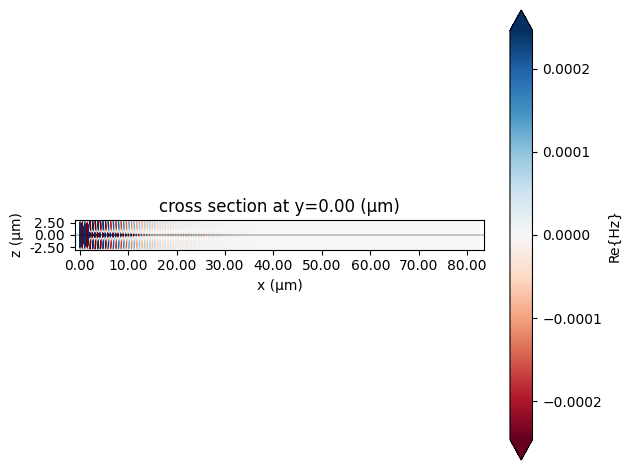

In [10]:
# plotting the fields
eme_data.plot_field("field", "Hz", "real", mode_index=0, eme_port_index=0)
plt.show()

We can note that the results are not correct, and there is a warning message in the simulation log.

As discussed in [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/), the plane size for a bend mode solver simulation must be sufficiently large to yield correct values for the losses. Small plane sizes can lead to negative values, which are disregarded by the EME solver, and hence the results will not be correct.

Running again, increasing the plane size:

In [11]:
eme_sim = get_bend_eme(
    bends=[(length, radius)],
    wvgIn=2,
    wvgOut=2,
    plane_size=(20, 20),
)

In [12]:
eme_data = web.run(eme_sim, task_name='eme',verbose = True)

18:23:17 -03 WARNING: Internal mode solver monitor '_eme_mode_solver_monitor_0' 
             has a large number (1.45e+05) of grid points. This can lead to     
             solver slow-down and increased cost. Consider making the size of   
             the component smaller, as long as the modes of interest decay by   
             the plane boundaries.                                              

             WARNING: Suppressed 2 WARNING messages.                            

             Created task 'eme' with task_id                                    
             'eme-dd54eb17-f2fe-49c4-b49c-87485cc5c959' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:23:20 -03 Maximum FlexCredit cost: 0.330. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:23:21 -03 status = success

18:26:44 -03 loading simulation from simulation_data.hdf5

We can now compare with a FDTD simulation:

In [13]:
x, y = eme2Curve(eme_sim)
fdtd_sim = get_fdtd(x, y, eme_sim)
fdtd_data = web.run(fdtd_sim, task_name='fdtd',verbose = True)

18:26:45 -03 Created task 'fdtd' with task_id                                   
             'fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=933542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=556437;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee\taskId]8;;\]8;id=933542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee\=]8;;\]8;id=402844;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee\fdve]8;;\]8;id=933542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee\-bfb6f1c7-74c]8;;\
             ]8;id=933542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bfb6f1c7-74c3-4c31-9be1-aaa744a35aee\3-4c31-9be1-aaa744a35aee']8;;\.

18:26:48 -03 Maximum FlexCredit cost: 9.566. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:26:49 -03 status = success

18:27:23 -03 loading simulation from simulation_data.hdf5

In [14]:
eme = float(eme_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs ** 2)
print("EME transmittance:  %f" % eme)

fdtd = float(fdtd_data["modeMon"].amps.sel(direction="+", mode_index=0).abs ** 2)
print("FDTD transmittance: %f" % fdtd)

EME transmittance:  0.991687
FDTD transmittance: 0.987893


As we can see, with a plane size large enough, the results are now correct and very close to those obtained with an FDTD simulation. Hence, starting with an analysis of the required plane size for a given simulation is always a good approach.

We can also plot the fields for both simulations. Although the EME simulation correctly captures the field decay, the meaning of the field plot for bent waveguides is not a true representation of the electric field, as it is in the FDTD simulation.

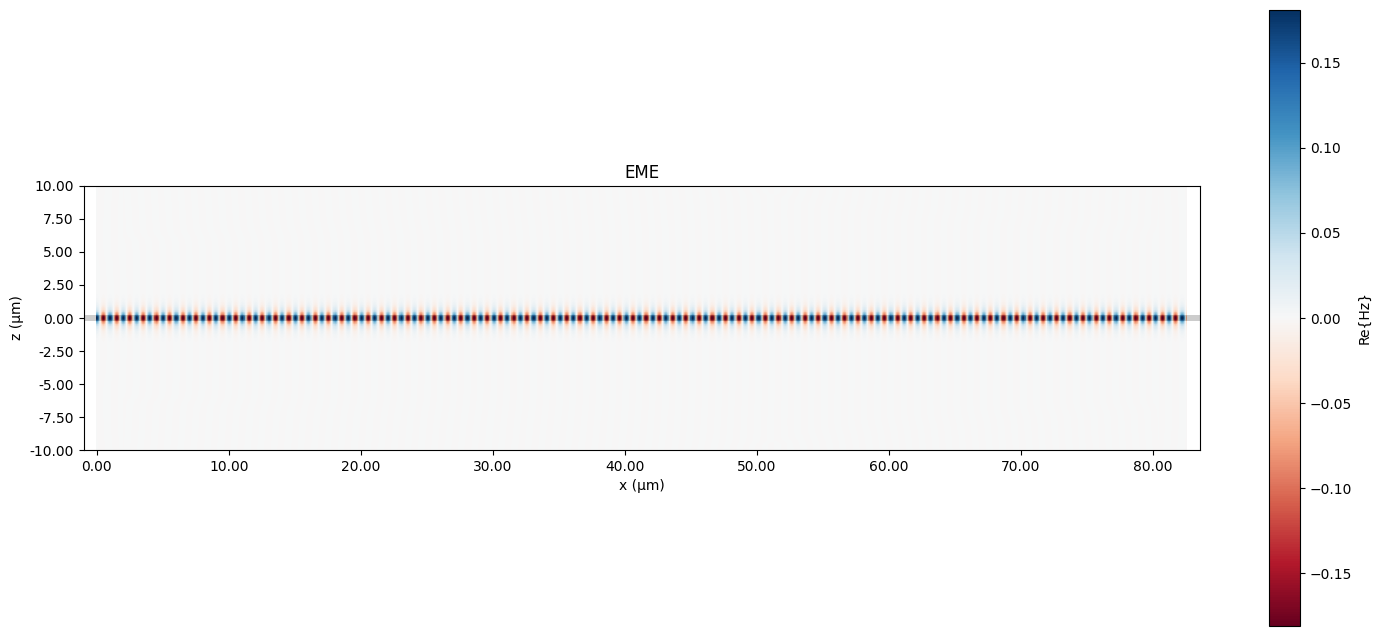

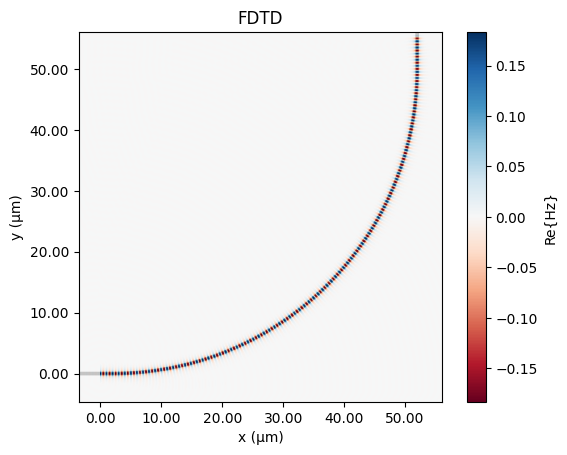

In [15]:
fig,ax = plt.subplots(figsize = (18,8))
eme_data.plot_field("field", "Hz", "real", mode_index=0, eme_port_index=0, robust=False,
                    ax=ax)
ax.set_title('EME')

fig,ax = plt.subplots()
fdtd_data.plot_field("field", "Hz", "real", robust=False,
                    ax=ax)
ax.set_title('FDTD')

plt.show()

## Circular S-Bend

Now, we can simulate a S-bend formed by two circular arcs, with the same radius and opposite sign, and compare with FDTD results. The s-bends are parametrized by their length and offset, hence, we will define an auxiliary function to retrieve the correct angle and curvature radius for a given bend.

In [16]:
def get_theta(length, offset):
    from scipy.optimize import fsolve

    def get_params(params, *args):
        theta = params
        length, offset = args
        r = (length / 2) / np.cos(theta - np.pi / 2)
        return abs(offset / 2 - (r * np.sin(theta - np.pi / 2) + r))

    theta = fsolve(get_params, (1,), args=(length, offset))[0]
    return (length / 2) / np.cos(theta - np.pi / 2), theta

Next, we will vary the length of the S-bend and compare the results obtained from the EME and FDTD simulations.

In [17]:
transmittance_eme = []
transmittance_fdtd = []

for length in [20, 40, 60, 80, 100]:
    r, theta = get_theta(length, 20)
    eme_sim = get_bend_eme(
        wvgIn=2,
        wvgOut=2,
        bends=[(theta * r, r), (theta * r, -r)],
        plane_size=(17, 17),
        num_modes=5,
    )

    x, y = eme2Curve(eme_sim)
    fdtd_sim = get_fdtd(x, y, eme_sim)

    eme_data = web.run(eme_sim, task_name='eme',verbose = True)
    fdtd_data = web.run(fdtd_sim, task_name='fdtd',verbose = True)

    fdtd = float(fdtd_data["modeMon"].amps.sel(direction="+", mode_index=0).abs ** 2)
    transmittance_fdtd.append(fdtd)

    eme = float(
        eme_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs ** 2
    )
    transmittance_eme.append(eme)

18:27:28 -03 WARNING: Internal mode solver monitor '_eme_mode_solver_monitor_0' 
             has a large number (1.06e+05) of grid points. This can lead to     
             solver slow-down and increased cost. Consider making the size of   
             the component smaller, as long as the modes of interest decay by   
             the plane boundaries.                                              

             WARNING: Suppressed 3 WARNING messages.                            

             Created task 'eme' with task_id                                    
             'eme-98f521b5-80ad-468a-a24f-0bc8269f8b9b' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:27:30 -03 Maximum FlexCredit cost: 0.139. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:27:31 -03 status = success

18:29:21 -03 loading simulation from simulation_data.hdf5

18:29:22 -03 Created task 'fdtd' with task_id                                   
             'fdve-0a801dac-1c94-4977-8d2a-3d128c149971' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=195366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a801dac-1c94-4977-8d2a-3d128c149971\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=549435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a801dac-1c94-4977-8d2a-3d128c149971\taskId]8;;\]8;id=195366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a801dac-1c94-4977-8d2a-3d128c149971\=]8;;\]8;id=259380;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a801dac-1c94-4977-8d2a-3d128c149971\fdve]8;;\]8;id=195366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a801dac-1c94-4977-8d2a-3d128c149971\-0a801dac-1c9]8;;\
             ]8;id=195366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a801dac-1c94-4977-8d2a-3d128c149971\4-4977-8d2a-3d128c149971']8;;\.

18:29:26 -03 Maximum FlexCredit cost: 2.493. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:29:27 -03 status = success

18:29:35 -03 loading simulation from simulation_data.hdf5

             WARNING: Internal mode solver monitor '_eme_mode_solver_monitor_0' 
             has a large number (1.06e+05) of grid points. This can lead to     
             solver slow-down and increased cost. Consider making the size of   
             the component smaller, as long as the modes of interest decay by   
             the plane boundaries.                                              

             WARNING: Suppressed 3 WARNING messages.                            

             Created task 'eme' with task_id                                    
             'eme-928f049f-7c15-404f-a0a5-f4d8e20cbeca' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:29:43 -03 Maximum FlexCredit cost: 0.186. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:29:45 -03 status = success

18:32:01 -03 loading simulation from simulation_data.hdf5

18:32:03 -03 Created task 'fdtd' with task_id                                   
             'fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=540666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=526201;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0\taskId]8;;\]8;id=540666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0\=]8;;\]8;id=539547;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0\fdve]8;;\]8;id=540666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0\-6bf85fa3-306]8;;\
             ]8;id=540666;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bf85fa3-3060-4e9f-b1ba-ccf22a3a63d0\0-4e9f-b1ba-ccf22a3a63d0']8;;\.

18:32:06 -03 Maximum FlexCredit cost: 4.027. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:32:07 -03 status = success

18:32:20 -03 loading simulation from simulation_data.hdf5

             WARNING: Internal mode solver monitor '_eme_mode_solver_monitor_0' 
             has a large number (1.06e+05) of grid points. This can lead to     
             solver slow-down and increased cost. Consider making the size of   
             the component smaller, as long as the modes of interest decay by   
             the plane boundaries.                                              

             WARNING: Suppressed 3 WARNING messages.                            

18:32:21 -03 Created task 'eme' with task_id                                    
             'eme-57b7b2a1-c836-4b5a-8a12-3465a74bc6cc' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:32:23 -03 Maximum FlexCredit cost: 0.243. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:32:24 -03 status = success

18:35:37 -03 loading simulation from simulation_data.hdf5

18:35:38 -03 Created task 'fdtd' with task_id                                   
             'fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=114374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=103012;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062\taskId]8;;\]8;id=114374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062\=]8;;\]8;id=337281;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062\fdve]8;;\]8;id=114374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062\-1dc4e9bc-5df]8;;\
             ]8;id=114374;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1dc4e9bc-5df4-434f-95c0-df4a0944a062\4-434f-95c0-df4a0944a062']8;;\.

18:35:42 -03 Maximum FlexCredit cost: 5.510. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:35:43 -03 status = success

18:36:07 -03 loading simulation from simulation_data.hdf5

             WARNING: Internal mode solver monitor '_eme_mode_solver_monitor_0' 
             has a large number (1.06e+05) of grid points. This can lead to     
             solver slow-down and increased cost. Consider making the size of   
             the component smaller, as long as the modes of interest decay by   
             the plane boundaries.                                              

             WARNING: Suppressed 3 WARNING messages.                            

             Created task 'eme' with task_id                                    
             'eme-4bf84c4f-9890-46d5-b330-9bc94d168aa7' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:36:16 -03 Maximum FlexCredit cost: 0.302. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:36:17 -03 status = success

18:39:24 -03 loading simulation from simulation_data.hdf5

18:39:25 -03 Created task 'fdtd' with task_id                                   
             'fdve-dc039019-2956-4252-9713-84664f6d335c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=871492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc039019-2956-4252-9713-84664f6d335c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=284398;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc039019-2956-4252-9713-84664f6d335c\taskId]8;;\]8;id=871492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc039019-2956-4252-9713-84664f6d335c\=]8;;\]8;id=475626;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc039019-2956-4252-9713-84664f6d335c\fdve]8;;\]8;id=871492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc039019-2956-4252-9713-84664f6d335c\-dc039019-295]8;;\
             ]8;id=871492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc039019-2956-4252-9713-84664f6d335c\6-4252-9713-84664f6d335c']8;;\.

18:39:29 -03 Maximum FlexCredit cost: 6.945. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:39:30 -03 status = success

18:39:50 -03 loading simulation from simulation_data.hdf5

             WARNING: Internal mode solver monitor '_eme_mode_solver_monitor_0' 
             has a large number (1.06e+05) of grid points. This can lead to     
             solver slow-down and increased cost. Consider making the size of   
             the component smaller, as long as the modes of interest decay by   
             the plane boundaries.                                              

             WARNING: Suppressed 3 WARNING messages.                            

             Created task 'eme' with task_id                                    
             'eme-f9c05602-3f17-465e-8f76-e62fe55cb69a' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:39:52 -03 Maximum FlexCredit cost: 0.363. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:39:53 -03 status = success

18:42:49 -03 loading simulation from simulation_data.hdf5

18:42:51 -03 Created task 'fdtd' with task_id                                   
             'fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=540132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=237585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2\taskId]8;;\]8;id=540132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2\=]8;;\]8;id=97405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2\fdve]8;;\]8;id=540132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2\-641e6851-bb8]8;;\
             ]8;id=540132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-641e6851-bb80-4ae2-a880-fa55dd1f95a2\0-4ae2-a880-fa55dd1f95a2']8;;\.

18:43:01 -03 Maximum FlexCredit cost: 8.335. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:43:02 -03 status = success

18:43:27 -03 loading simulation from simulation_data.hdf5

Plotting the results, we can see that there is a good match between FDTD and EME transmittance.

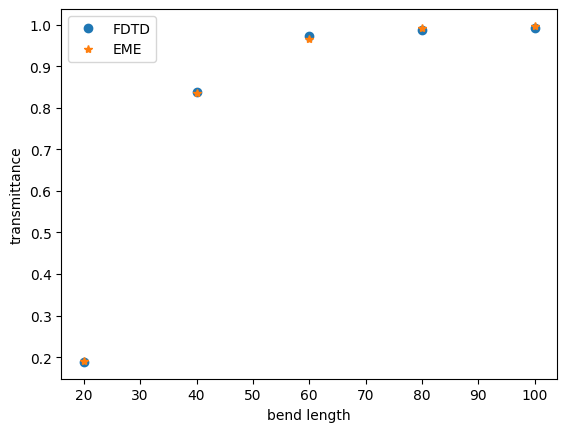

In [18]:
fig, ax = plt.subplots()
ax.plot([20, 40, 60, 80, 100], transmittance_fdtd, "o", label="FDTD")
ax.plot([20, 40, 60, 80, 100], transmittance_eme, "*", label="EME")
ax.set_ylabel('transmittance')
ax.set_xlabel('bend length')

ax.legend()

plt.show()

We can also work with a combination of s-bends, that can work as arms for interferometers. In this case, we will have a very large FDTD simulation, that costs around 10 FC, while the EME simulation will cost less then 1.

In [19]:
theta = np.pi / 2
r = 20

eme_sim = get_bend_eme(
    wvgIn=2,
    wvgOut=2,
    bends=[
        (theta * r, r),
        (theta * r, -r),
        (theta * r, -r),
        (theta * r, r),
        (theta * r, -r),
        (theta * r, r),
        (theta * r, r),
        (theta * r, -r),
    ],
    plane_size=(15, 15),
    num_modes=5,
)
x, y = eme2Curve(eme_sim)
fdtd_sim = get_fdtd(x, y, eme_sim)

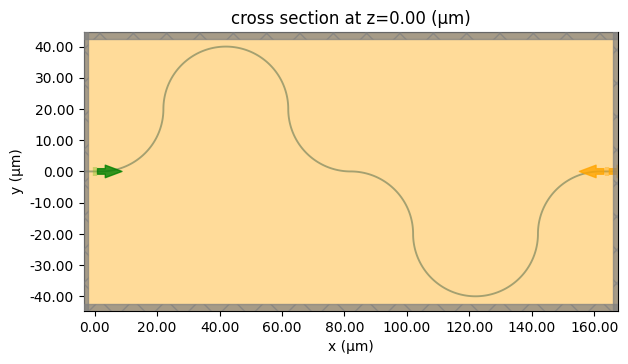

In [20]:
# visualizing the structure

fdtd_sim.plot(z=0)
plt.show()

In [21]:
eme_data = web.run(eme_sim, task_name='eme',verbose = True)
fdtd_data = web.run(fdtd_sim, task_name='fdtd',verbose = True)


fdtd = float(fdtd_data["modeMon"].amps.sel(direction="+", mode_index=0).abs ** 2)


eme = float(eme_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs ** 2)

             Created task 'eme' with task_id                                    
             'eme-6eb213a5-d7c1-4a04-8563-f19ecaa99ee3' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:43:30 -03 Maximum FlexCredit cost: 0.770. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:43:31 -03 status = success

18:49:47 -03 loading simulation from simulation_data.hdf5

18:49:50 -03 Created task 'fdtd' with task_id                                   
             'fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=340067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=5074;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3\taskId]8;;\]8;id=340067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3\=]8;;\]8;id=353587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3\fdve]8;;\]8;id=340067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3\-d10e3074-11e]8;;\
             ]8;id=340067;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d10e3074-11ec-46ad-8e3f-b7ff2cddfcd3\c-46ad-8e3f-b7ff2cddfcd3']8;;\.

18:49:54 -03 Maximum FlexCredit cost: 29.766. Minimum cost depends on task      
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:49:56 -03 status = success

18:51:22 -03 loading simulation from simulation_data.hdf5

As we can see, the results are very close, but the FC cost for the EME simulation is much smaller.

In [22]:
print("fdtd transmittance: %f\neme transmittance: %f" % (fdtd, eme))

fdtd transmittance: 0.176971
eme transmittance: 0.169626


We can plot the fields of both simulations, and observe the intensity decreasing as it propagates through the waveguide.

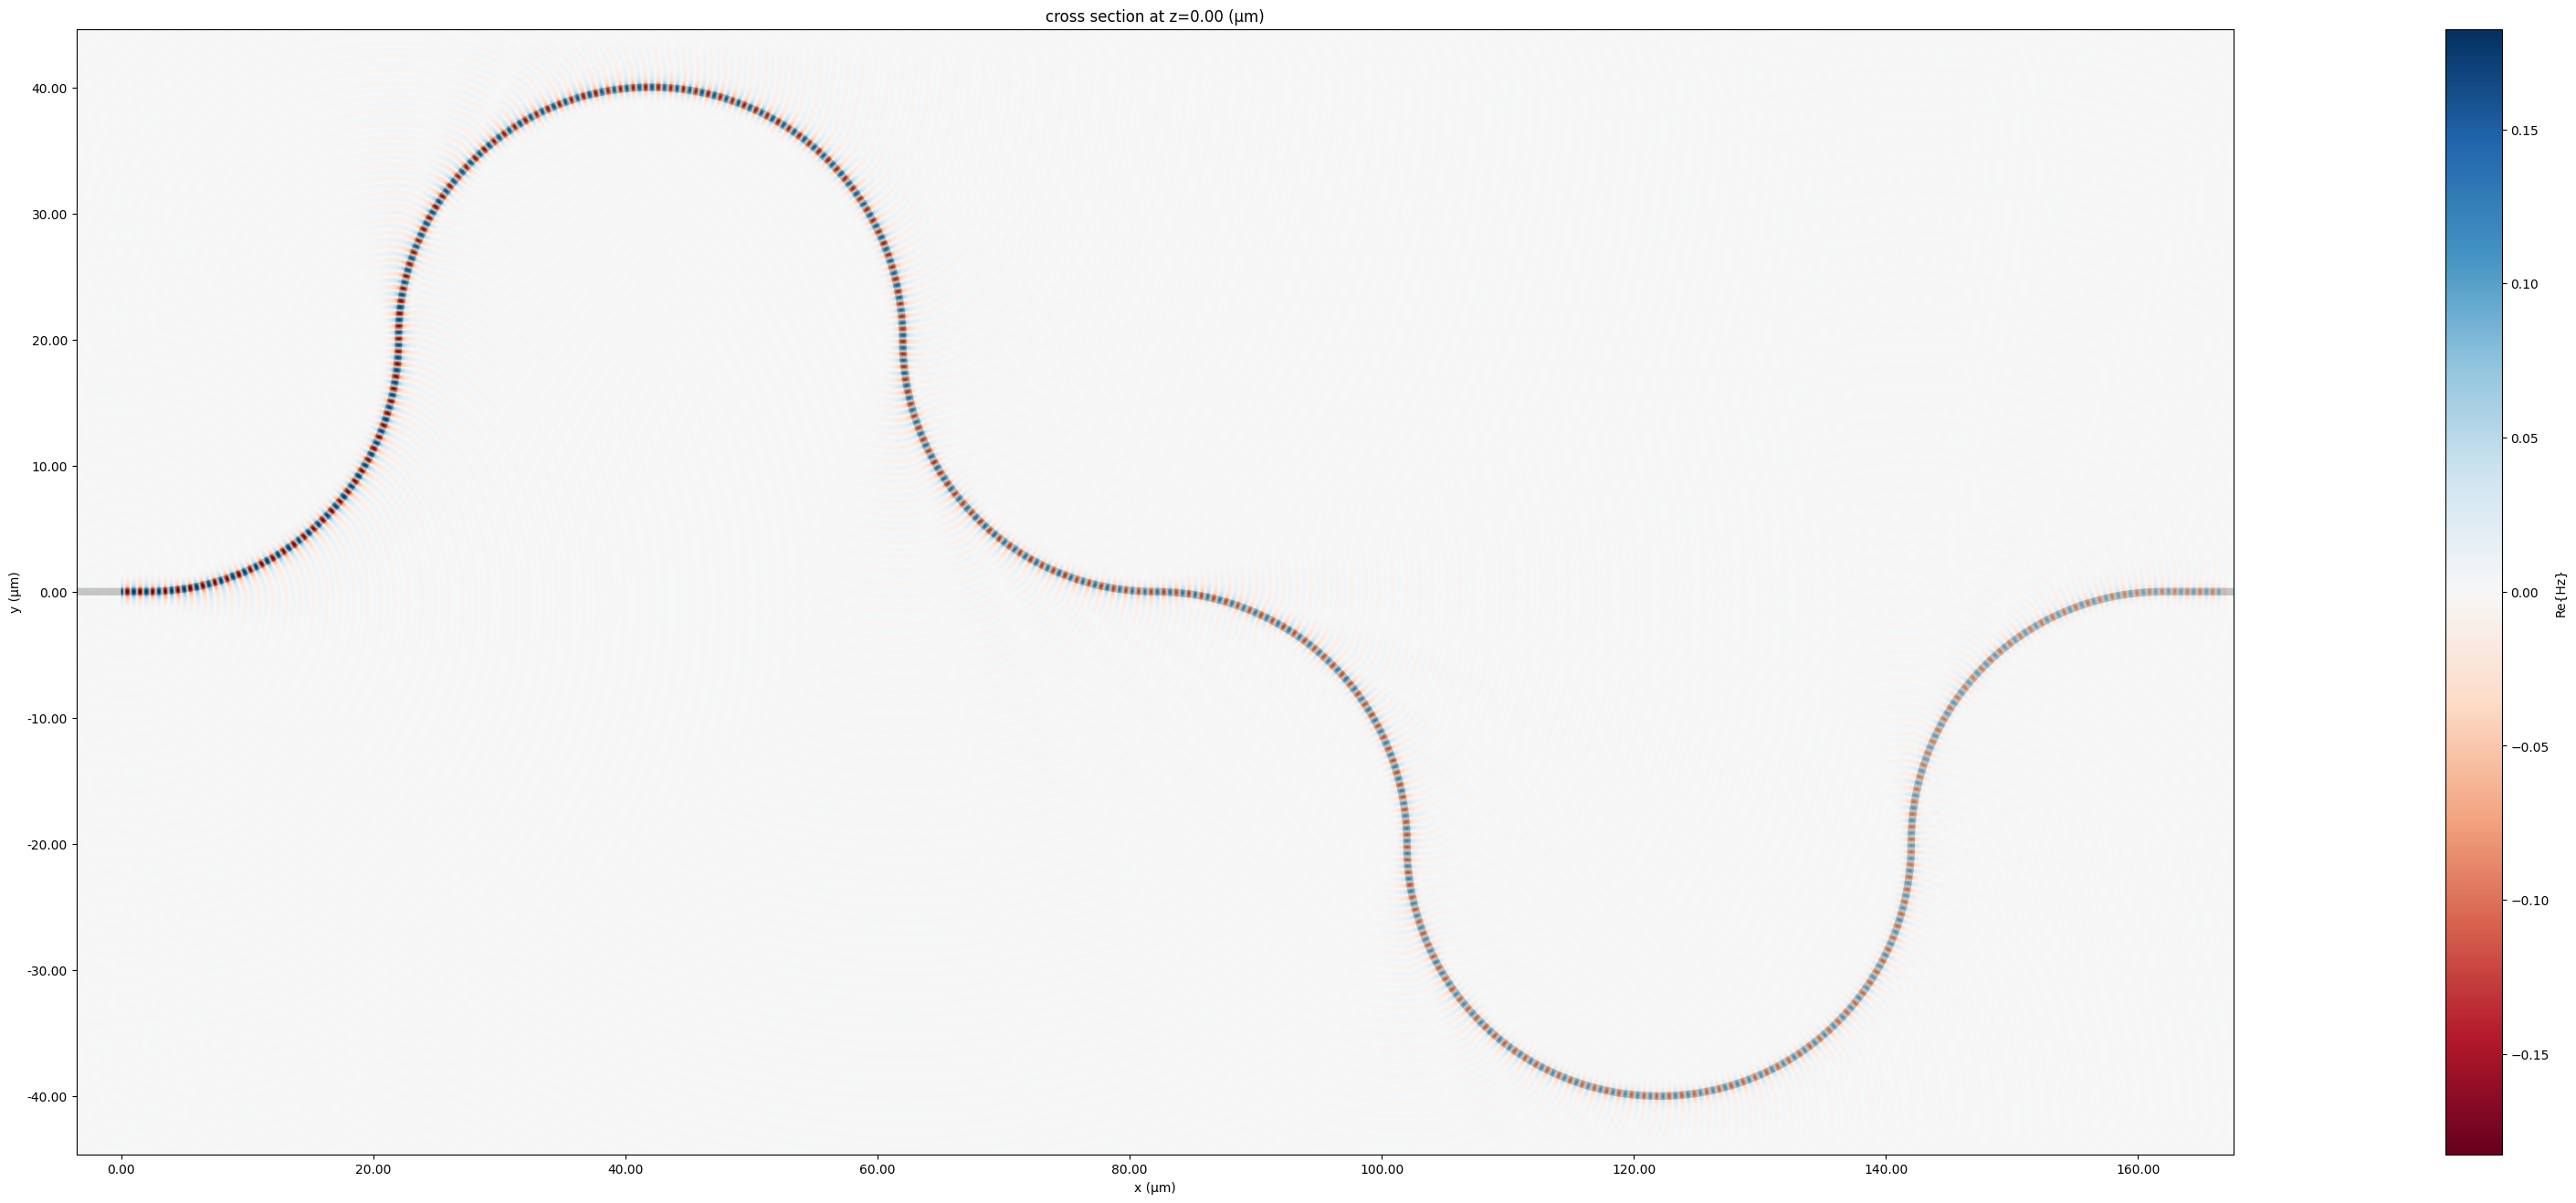

In [23]:
fig, ax = plt.subplots(figsize=(60, 16))
fdtd_data.plot_field("field", "Hz", "real", robust=False, ax=ax)
plt.show()

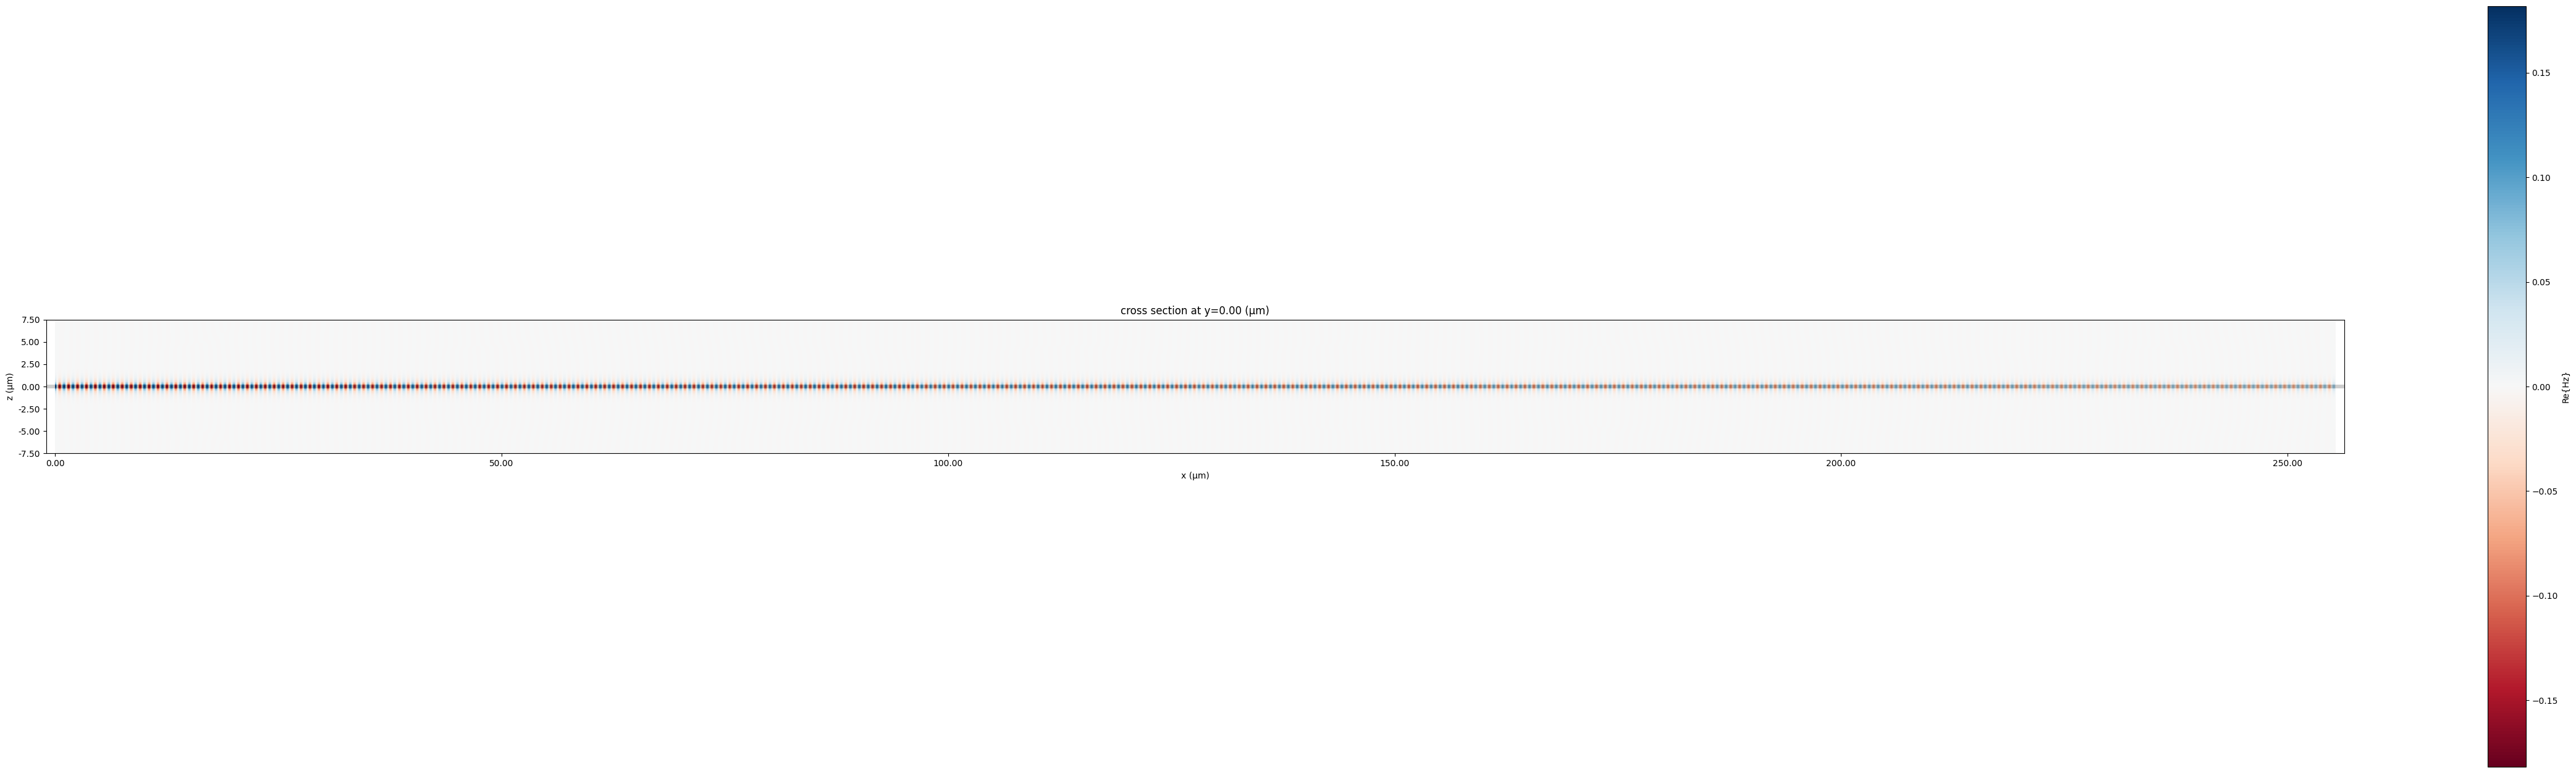

In [24]:
fig, ax = plt.subplots(figsize=(60, 16))
eme_data.plot_field(
    "field", "Hz", "real", mode_index=0, eme_port_index=0, robust=False, ax=ax
)
plt.show()

## Euler Bend

We can use a similar approach as in the previous examples to simulate an arbitrary curve that is not formed by circular arcs, such as an S-bend formed with Euler curves, similar to [this](https://www.flexcompute.com/tidy3d/examples/notebooks/EulerWaveguideBend/) example notebook.

As discussed in [this](https://www.flexcompute.com/tidy3d/examples/notebooks/EMESolver/) example, for an adiabatically varying waveguide, the EME simulation can be a good approximation of the real structure. In this case, we will approximate the real structure using an EME grid accounting for the local radius at different sections. 

First, we will define a function to create the Euler bend:


In [25]:
def euler_curve(A=2.4, L=10, num_points=1000):

    from scipy import integrate

    Ls = np.linspace(0, L, num_points)  # L at (x1,y1)
    x1 = np.zeros(len(Ls))  # x coordinate of the clothoid curve
    y1 = np.zeros(len(Ls))  # y coordinate of the clothoid curve

    # compute x1 and y1 using the above integral equations

    y1 = np.array(
        [
            integrate.quad(lambda theta: A * np.sin(theta**2 / 2), 0, L / A)[0]
            for L in Ls
        ]
    )
    x1 = np.array(
        [
            integrate.quad(lambda theta: A * np.cos(theta**2 / 2), 0, L / A)[0]
            for L in Ls
        ]
    )

    return x1, y1


def euler_bend(offset, length, num_points=1000):

    from scipy.optimize import fsolve

    def get_params(params):
        A, L = params

        x1, y1 = euler_curve(A=A, num_points=num_points, L=L)

        return (abs(x1[-1] - length / 2) ** 2, abs(y1[-1] - offset / 2) ** 2)

    A, L = fsolve(get_params, (1, 1))
    x1, y1 = euler_curve(A=A, num_points=num_points, L=L)

    x = np.append(x1, np.flip(-x1 + 2 * x1[-1]))
    y = np.append(y1, np.flip(-y1 + 2 * y1[-1]))

    return x, y

Next, we define a function for calculating the local curvature radius, as $R = \frac{(1 + y'^2)^{\frac{3}{2}}}{y''}$:

In [26]:
def get_local_radius(x, y):

    yd = np.gradient(y, x, edge_order=2)
    ydd = np.gradient(yd, x, edge_order=2)
    R = ((1 + yd**2) ** (3 / 2)) / ydd

    return R

Now, lets visualize the Euler S-bend and the local curvature radius:

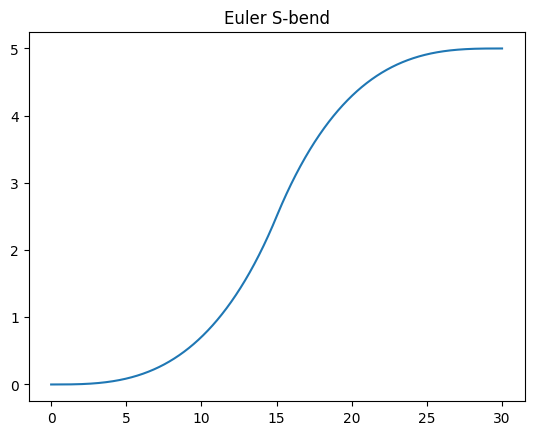

In [27]:
x_euler, y_euler = euler_bend(offset=5, length=30)
local_radius = get_local_radius(x_euler, y_euler)

fig, ax = plt.subplots()
ax.set_title('Euler S-bend')
ax.plot(x_euler, y_euler)

plt.show()

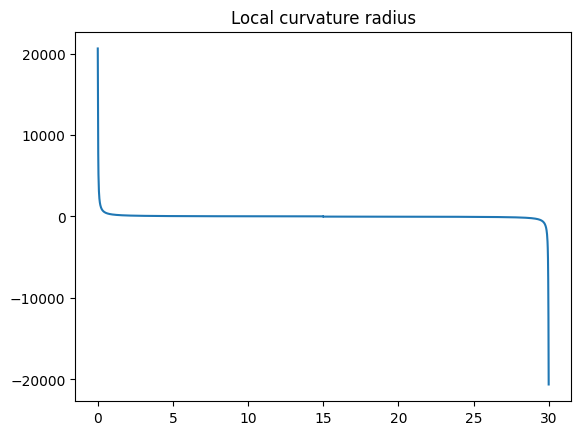

In [28]:
fig, ax = plt.subplots()
ax.set_title('Local curvature radius')
ax.plot(x_euler, local_radius)

plt.show()

As we can note, an uniformly spaced grid might not be the most efficient approach, as the local radius varies much more in some sections than in others. We can visualize this by looking at its derivative:

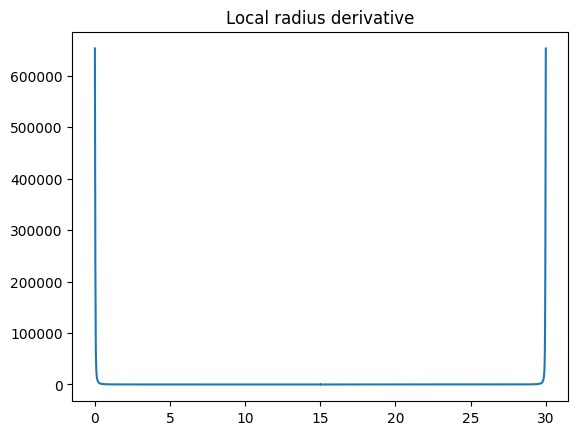

In [29]:
dR = np.gradient(local_radius, x_euler, edge_order=2)
fig, ax = plt.subplots()
ax.set_title('Local radius derivative')
ax.plot(x_euler, abs(dR))

plt.show()

One possible approach is to divide the curve into sections based on its derivative value. This way, sections with greater variation will have a higher grid density, better capturing the waveguide radius change.

We will create a function `get_bends` that will divide the curve into tree sections, according with the local radius derivative values, and create even spaced grid cells into these sections.

In [30]:
# function to create evenly distributed grid cells into one particular section
def get_positions(points, n_grid):
    if n_grid >= len(points):
        return np.arange(0, len(points), 1)
    indices = np.linspace(0, len(points) - 1, n_grid, dtype=int)
    return indices


def get_bends(x_euler, y_euler, grid_per_section=5, plot=False):

    # local radius and its derivatives
    local_radius = get_local_radius(x_euler, y_euler)
    dR = np.gradient(local_radius, x_euler, edge_order=2)

    # slice the data in chunks based on mean and standard deviation
    mean = np.nanmean(abs(dR))
    std = np.nanstd(abs(dR))

    section1 = abs(dR) >= mean + std
    section2 = (abs(dR) < mean + std) & (abs(dR) >= mean)
    section3 = abs(dR) < mean

    section1_points = get_positions(x_euler[section1], grid_per_section)
    section2_points = get_positions(x_euler[section2], grid_per_section)
    section3_points = get_positions(x_euler[section3], grid_per_section)

    # discontinuity points in the derivative that are continuous in the local radius curve
    discontinuity = x_euler[np.isnan(dR)][~np.isnan(local_radius[np.isnan(dR)])]
    discontinuity_y = y_euler[np.isnan(dR)][~np.isnan(local_radius[np.isnan(dR)])]
    discontinuity_radius = local_radius[np.isnan(dR)][
        ~np.isnan(local_radius[np.isnan(dR)])
    ]

    # retrieving the x position and local radius of the EME grid
    x_positions = np.concatenate(
        [
            x_euler[section1][section1_points],
            x_euler[section2][section2_points],
            x_euler[section3][section3_points],
            discontinuity,
            [x_euler[-1]],
        ]
    )
    sort = np.argsort(x_positions)
    x_positions = x_positions[sort]
    radius = np.concatenate(
        [
            local_radius[section1][section1_points],
            local_radius[section2][section2_points],
            local_radius[section3][section3_points],
            discontinuity_radius,
            [local_radius[-1]],
        ]
    )
    radius = radius[sort][1:]

    # transform positions in length
    length = np.diff(x_positions)

    # creating the list of tuples
    bends = list(zip(length, radius))

    # plot the grid points
    if plot:
        fig, ax = plt.subplots()
        ax.plot(x_euler, y_euler)
        ax.plot(
            x_euler[section1][section1_points], y_euler[section1][section1_points], "o",
            label = 'section 1'
        )
        ax.plot(
            x_euler[section2][section2_points],
            y_euler[section2][section2_points],
            "o",
            label = 'section 2'
        )
        ax.plot(
            x_euler[section3][section3_points], y_euler[section3][section3_points], "o",
            label = 'section 3'
        )
        ax.plot(discontinuity, discontinuity_y, "*",label = 'discontinuity')
        
        ax.legend()

        plt.show()

    return bends

Now, let's visualize an example. As we can note, the grid points are densely packed at the edges of the S-bend, where the local radius experiences more variation.

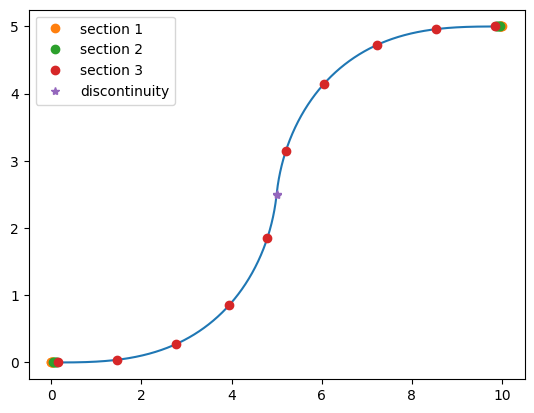

In [31]:
x_euler, y_euler = euler_bend(offset=5, length=10)
bends = get_bends(x_euler, y_euler, grid_per_section=10, plot=True)

Next, we will vary the length of the S-bend for a fixed offset value, and compare the results with EME and FDTD: 

In [32]:
transmittance_fdtd = []
transmittance_eme = []

grids = 10
for l in [30, 50, 80, 100]:

    x_euler, y_euler = euler_bend(offset=5, length=l)
    bends = get_bends(x_euler, y_euler, grid_per_section=grids, plot=False)

    eme_sim = get_bend_eme(
        wvgIn=2, wvgOut=2, bends=bends, plane_size=(15, 15), num_modes=5
    )
    fdtd_sim = get_fdtd(x_euler, y_euler, eme_sim)


    eme_data = web.run(eme_sim, task_name='eme',verbose = True)
    fdtd_data = web.run(fdtd_sim, task_name='fdtd',verbose = True)

    fdtd = float(fdtd_data["modeMon"].amps.sel(direction="+", mode_index=0).abs ** 2)
    eme = float(
        eme_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs ** 2
    )

    transmittance_fdtd.append(fdtd)
    transmittance_eme.append(eme)

18:51:44 -03 Created task 'eme' with task_id                                    
             'eme-fd6aa115-76ea-4a71-ae4c-387d935ef75a' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:51:48 -03 Maximum FlexCredit cost: 0.273. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:51:50 -03 status = success

18:57:26 -03 loading simulation from simulation_data.hdf5

18:57:29 -03 Created task 'fdtd' with task_id                                   
             'fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=485766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=465847;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6\taskId]8;;\]8;id=485766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6\=]8;;\]8;id=935910;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6\fdve]8;;\]8;id=485766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6\-14d27e55-752]8;;\
             ]8;id=485766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-14d27e55-7527-46ea-8e29-1cbeb9b889c6\7-46ea-8e29-1cbeb9b889c6']8;;\.

18:57:32 -03 Maximum FlexCredit cost: 1.342. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:57:33 -03 status = success

18:57:39 -03 loading simulation from simulation_data.hdf5

18:57:42 -03 Created task 'eme' with task_id                                    
             'eme-f6ed708e-db6a-451e-b406-f446eb2727c5' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

18:57:51 -03 Maximum FlexCredit cost: 0.329. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

18:57:52 -03 status = success

19:03:46 -03 loading simulation from simulation_data.hdf5

19:03:48 -03 Created task 'fdtd' with task_id                                   
             'fdve-9e5fb8a5-f789-4b5b-a513-07abab422259' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=987510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e5fb8a5-f789-4b5b-a513-07abab422259\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=70894;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e5fb8a5-f789-4b5b-a513-07abab422259\taskId]8;;\]8;id=987510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e5fb8a5-f789-4b5b-a513-07abab422259\=]8;;\]8;id=178168;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e5fb8a5-f789-4b5b-a513-07abab422259\fdve]8;;\]8;id=987510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e5fb8a5-f789-4b5b-a513-07abab422259\-9e5fb8a5-f78]8;;\
             ]8;id=987510;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9e5fb8a5-f789-4b5b-a513-07abab422259\9-4b5b-a513-07abab422259']8;;\.

19:03:52 -03 Maximum FlexCredit cost: 2.046. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:03:53 -03 status = success

19:04:00 -03 loading simulation from simulation_data.hdf5

19:04:02 -03 Created task 'eme' with task_id                                    
             'eme-c13bcfef-0a25-4adb-8c2a-7fa2a9460599' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

19:04:05 -03 Maximum FlexCredit cost: 0.413. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:04:06 -03 status = success

19:10:33 -03 loading simulation from simulation_data.hdf5

19:10:36 -03 Created task 'fdtd' with task_id                                   
             'fdve-e32914c4-8041-4e97-b409-ee491d43a0bc' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=786718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e32914c4-8041-4e97-b409-ee491d43a0bc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=79732;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e32914c4-8041-4e97-b409-ee491d43a0bc\taskId]8;;\]8;id=786718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e32914c4-8041-4e97-b409-ee491d43a0bc\=]8;;\]8;id=752695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e32914c4-8041-4e97-b409-ee491d43a0bc\fdve]8;;\]8;id=786718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e32914c4-8041-4e97-b409-ee491d43a0bc\-e32914c4-804]8;;\
             ]8;id=786718;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e32914c4-8041-4e97-b409-ee491d43a0bc\1-4e97-b409-ee491d43a0bc']8;;\.

19:10:39 -03 Maximum FlexCredit cost: 3.083. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:10:40 -03 status = success

19:10:50 -03 loading simulation from simulation_data.hdf5

19:10:52 -03 Created task 'eme' with task_id                                    
             'eme-79c40e7a-e65b-41b7-a08e-9b26caed87c1' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

19:10:55 -03 Maximum FlexCredit cost: 0.469. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:10:56 -03 status = success

19:17:48 -03 loading simulation from simulation_data.hdf5

19:17:51 -03 Created task 'fdtd' with task_id                                   
             'fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=409772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=149559;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f\taskId]8;;\]8;id=409772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f\=]8;;\]8;id=413070;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f\fdve]8;;\]8;id=409772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f\-c3e973cd-5b9]8;;\
             ]8;id=409772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c3e973cd-5b98-4b7a-be4b-929b69ea5f6f\8-4b7a-be4b-929b69ea5f6f']8;;\.

19:17:54 -03 Maximum FlexCredit cost: 3.764. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:17:55 -03 status = success

19:18:06 -03 loading simulation from simulation_data.hdf5

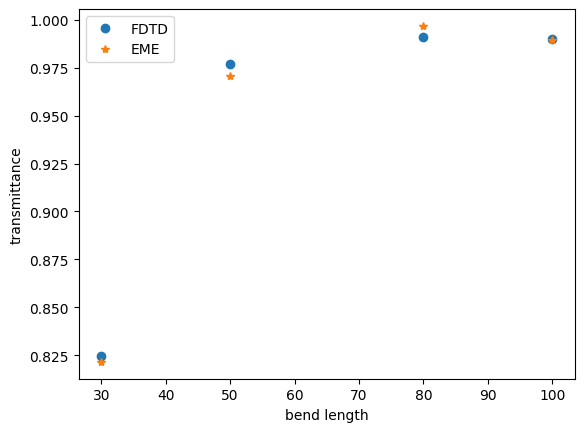

In [33]:
# plot results
fig, ax = plt.subplots()

ax.plot([30, 50, 80, 100], transmittance_fdtd, 'o',label = 'FDTD')
ax.plot([30, 50, 80, 100], transmittance_eme, '*',label = 'EME')
ax.set_ylabel('transmittance')
ax.set_xlabel('bend length')
ax.legend()

plt.show()

As we can see, a number of 10 grid cells for each section allows good convergence with FDTD simulations.

Finally, we can try the same approach for a bigger S-bend, where the cost advantage of the EME solver becomes more apparent.

In [34]:
x_euler, y_euler = euler_bend(offset=80, length=150)
bends = get_bends(x_euler, y_euler, grid_per_section=grids, plot=False)

eme_sim = get_bend_eme(wvgIn=2, wvgOut=2, bends=bends, plane_size=(15, 15), num_modes=5)
fdtd_sim = get_fdtd(x_euler, y_euler, eme_sim)


eme_data = web.run(eme_sim, task_name='eme',verbose = True)
fdtd_data = web.run(fdtd_sim, task_name='fdtd',verbose = True)


19:18:08 -03 Created task 'eme' with task_id                                    
             'eme-44eb96e7-4e0a-42a8-a6a5-f81842a86f92' and task_type 'EME'.

             Tidy3D's EME solver is currently in the beta stage. Cost of EME    
             simulations is subject to change in the future.

19:18:11 -03 Maximum FlexCredit cost: 0.608. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:18:12 -03 status = success

19:26:01 -03 loading simulation from simulation_data.hdf5

19:26:05 -03 Created task 'fdtd' with task_id                                   
             'fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=507688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=259424;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d\taskId]8;;\]8;id=507688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d\=]8;;\]8;id=471900;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d\fdve]8;;\]8;id=507688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d\-a6ba79e2-a57]8;;\
             ]8;id=507688;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a6ba79e2-a577-411e-8547-5905f0c3f04d\7-411e-8547-5905f0c3f04d']8;;\.

19:26:09 -03 Maximum FlexCredit cost: 28.133. Minimum cost depends on task      
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

19:26:10 -03 status = success

19:27:35 -03 loading simulation from simulation_data.hdf5

As we can see, there is only a small deviation compared to the FDTD simulation, although the EME simulation costs around 10 times less.

In [35]:
fdtd = float(fdtd_data["modeMon"].amps.sel(direction="+", mode_index=0).abs ** 2)
eme = float(eme_data.smatrix.S21.isel(mode_index_in=0, mode_index_out=0, f=0).abs ** 2)

print("fdtd transmittance: %f\neme transmittance: %f" % (fdtd, eme))

fdtd transmittance: 0.944534
eme transmittance: 0.951268


## Final Remarks

As we can see, the EME solver can be a good choice instead of FDTD when calculating very long bend waveguides. For waveguides formed only by circular arcs, the simulation setup is straightforward, and the error compared with an FDTD simulation is minimal.

On the other hand, for bends of arbitrary shapes, the simulation setup is more demanding, and the EME simulation becomes an approximation, as the structure is divided into cells and not all local curvature points are considered. Nevertheless, for a sufficient number of cells, the results deviate from an FDTD simulation by less than 3%, making it a suitable tool for simulating very large structures with minimal runtime and computational cost.

Additionally, it is worth emphasizing that the EME method will only yield low error for systems with slow variations, and where waveguides propagate along the same axis. For example, a system with two waveguides propagating with different curvatures would not be well-defined in an EME simulation.

Below, we summarize the pros and cons of each method:

| EME Solver                                                  | FDTD Solver                                                |
|-------------------------------------------------------------|------------------------------------------------------------|
| Easy setup for circular arc sections                        | Can be demanding for a complex combination of circular arcs|
| Setup is demanding for bends of arbitrary shapes            | For shapes based on mathematical equations, the geometry setup is straightforward|
| Low number of unknowns. Ideal for long structures           | Number of grid points can be very large for long waveguides|
| Errors due to grid and cell discretization                  | Higher accuracy.                                           |
| Works well for a limited range of problems                  | General method                                             |

